<a href="https://colab.research.google.com/github/pfylim/education/blob/trading/Copy_of_Cointegration_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is an example that belongs to https://stats.stackexchange.com/questions/581703/why-does-the-order-of-the-pair-of-series-passed-to-a-cointegration-test-matter

In [ ]:
!pip install yfinance

In [1]:
import itertools

import pandas as pd
import seaborn as sns
import yfinance as yf

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import coint

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
stocks = ["SILJ", "USO", "EWA", "EWC"]
df = yf.download(stocks, interval="1d", start='2020-01-01', end='2022-01-01')["Adj Close"] # daily prices

[*********************100%%**********************]  4 of 4 completed


In [3]:
df.head(3)

Ticker,EWA,EWC,SILJ,USO
Date,,,,
2020-01-02,19.357843,27.496677,12.124119,102.480003
2020-01-03,19.153538,27.359100,11.898326,105.440002
2020-01-06,19.255692,27.496677,11.643081,105.279999


In [5]:
df.shape

(505, 4)

<Axes: xlabel='Date'>

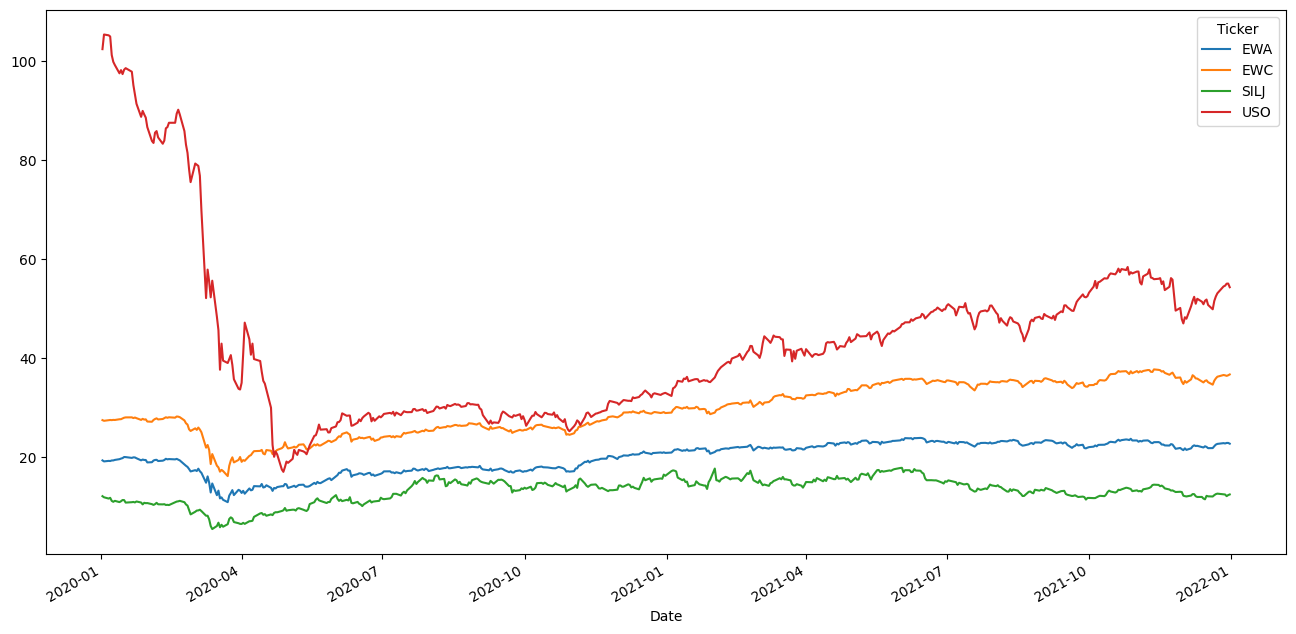

In [6]:
df.plot(figsize=(16,8))

In [7]:
pairs = list(itertools.combinations(stocks, 2))

# Create dataframes to represent heat maps of cointegration pvalues
df_coint = pd.DataFrame(index=stocks, columns=stocks, dtype=float)
df_coint.fillna(0, inplace=True)

In [8]:
# analyze cointegration
for pair in pairs:

    df_coint[pair[0]][pair[1]] = coint(df[pair[0]], df[pair[1]])[1] # pvalue
    df_coint[pair[1]][pair[0]] = coint(df[pair[1]], df[pair[0]])[1] # pvalue

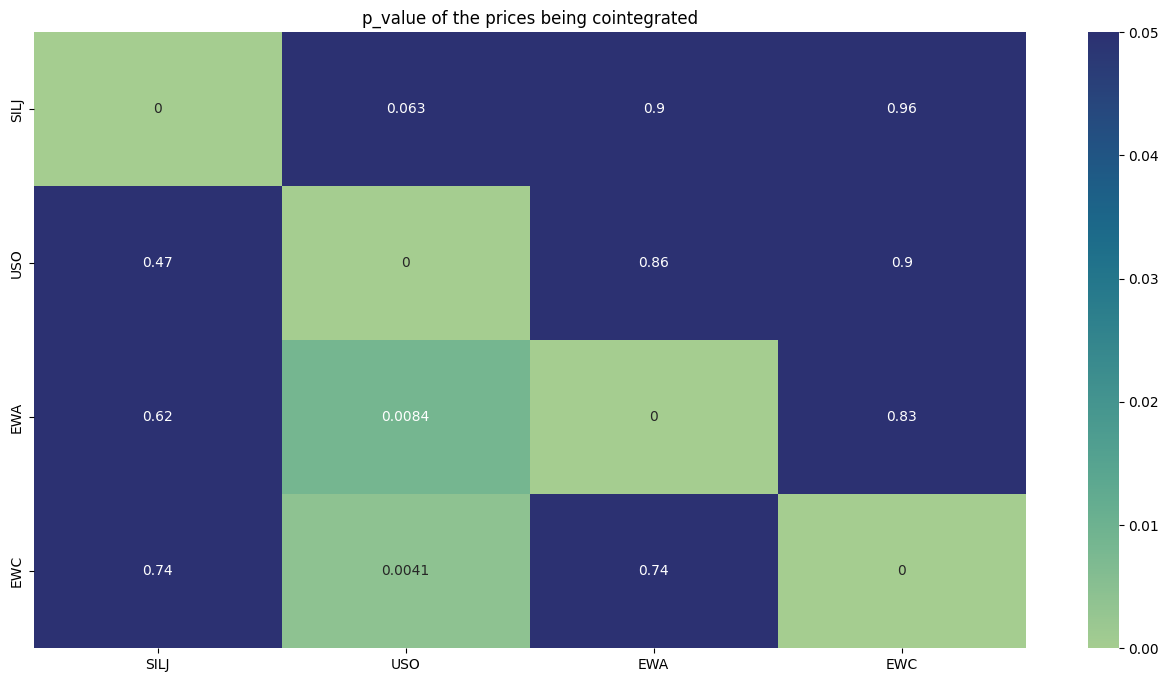

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(df_coint, vmax=.05, cmap="crest", annot=True)
ax.set_title(f"p_value of the prices being cointegrated")
plt.show()

In [10]:
# Manually verifying coint for USO and EWC
pair = ("USO", "EWC")
print(coint(df[pair[0]], df[pair[1]]))
print(coint(df[pair[1]], df[pair[0]]))

(-4.163418489094322, 0.004141659729102131, array([-3.91830195, -3.34828007, -3.05287579]))
(-1.011736762297539, 0.9005985407939525, array([-3.91830195, -3.34828007, -3.05287579]))


### User Christoph Hanck suggested to do a Linear Regression and compare the residuals.

In [11]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

### Linear Regression with y=EWC and X=USO

In [12]:
# Calculate hedge ratio with regression based on price data
# LinearRegression().fit() expects 2D numpy arrays. We can use Series.values
# to get the values as a numpy array. Since these are 1D arrays,
# we can use numpy.reshape(-1,1).
a_0 = df[pair[0]].values.reshape(-1, 1)
a_1 = df[pair[1]].values.reshape(-1, 1)

lr = LinearRegression()
lr.fit(a_0, a_1) # lr.fit(X, y)

hedge_ratio = lr.coef_[0][0]
intercept = lr.intercept_[0]

spread =  df[pair[1]] - (df[pair[0]] * hedge_ratio + intercept)

In [13]:
# Augmented Dickey-Fuller test to check if the spread is stationary.
# If yes, the series are cointegrated.
pvalue = adfuller(spread)[1]
print(f"Spread stationary at p_level .05: {pvalue < .05}; pvalue: {pvalue}")

Spread stationary at p_level .05: False; pvalue: 0.7377837338511956


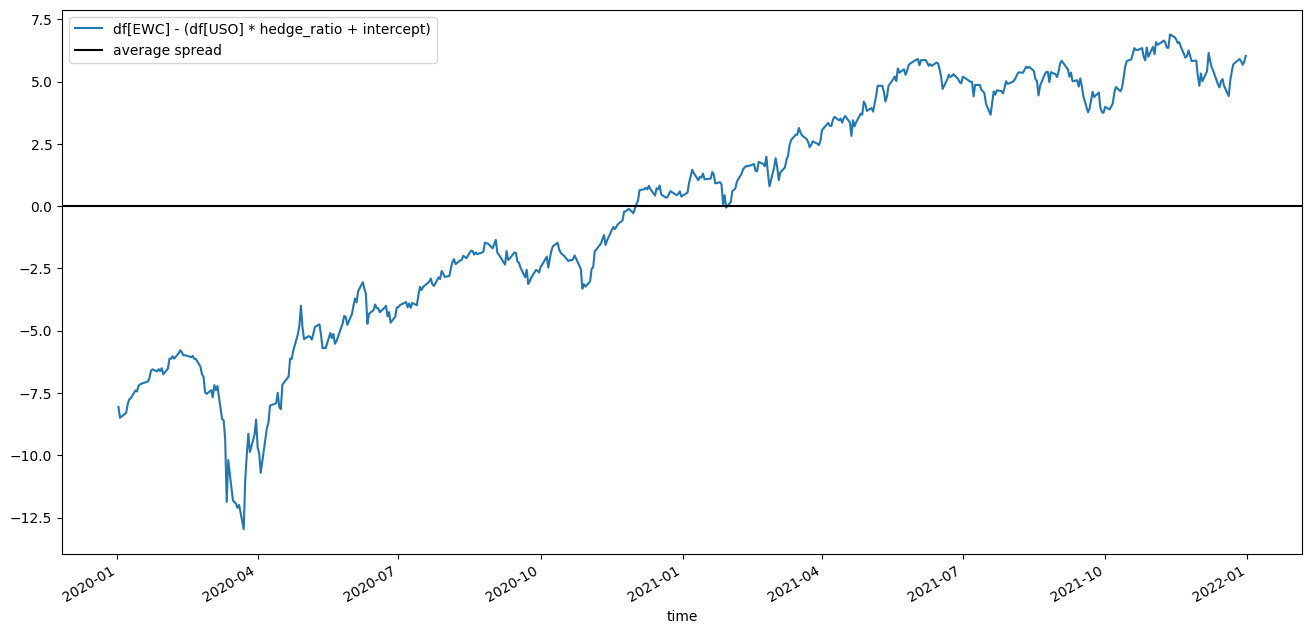

hedge_ratio: 0.10100176565975114 intercept: 25.208260734564902


In [14]:
spread.plot(figsize=(16,8))
plt.axhline(spread.mean(), color='black')
plt.xlabel("time")
plt.legend([f"df[{pair[1]}] - (df[{pair[0]}] * hedge_ratio + intercept)", "average spread"])
plt.show()
print(f"hedge_ratio: {hedge_ratio} intercept: {intercept}")

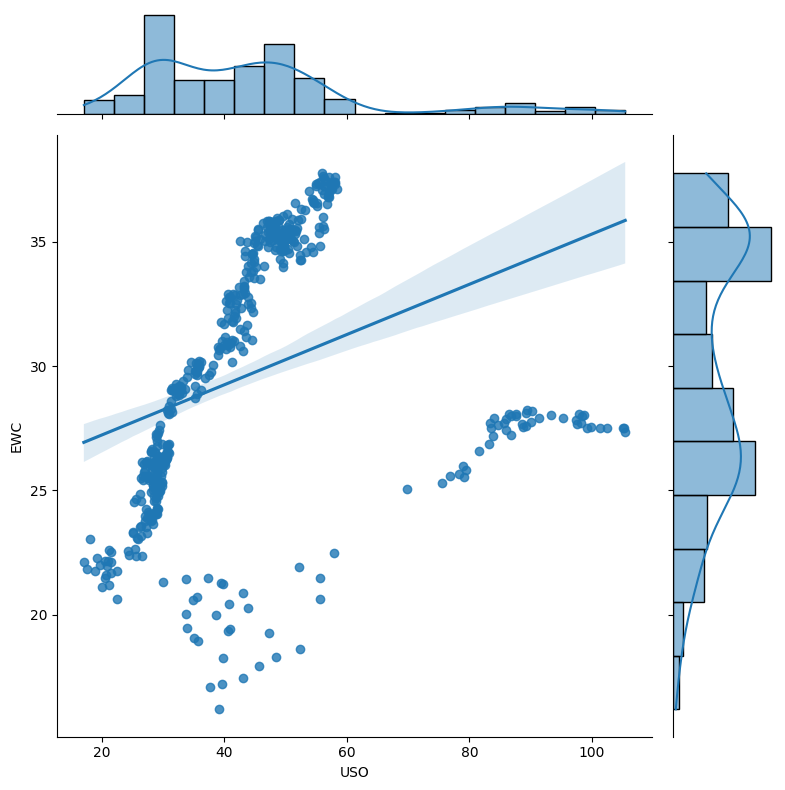

In [15]:
sns.jointplot(x=df[pair[0]], y=df[pair[1]], height=8, kind="reg")
plt.show()

### Linear Regression with y=USO and X=EWC

In [17]:
lr = LinearRegression()
lr.fit(a_1, a_0) # lr.fit(X, y)

hedge_ratio = lr.coef_[0][0]
intercept = lr.intercept_[0]

spread =  df[pair[0]] - (df[pair[1]] * hedge_ratio + intercept)

In [18]:
# Augmented Dickey-Fuller test to check if the spread is stationary.
# If yes, the series are cointegrated.
pvalue = adfuller(spread)[1]
print(f"Spread stationary at p_level .05: {pvalue < .05}; pvalue: {pvalue}")

Spread stationary at p_level .05: True; pvalue: 0.00023488255333203585


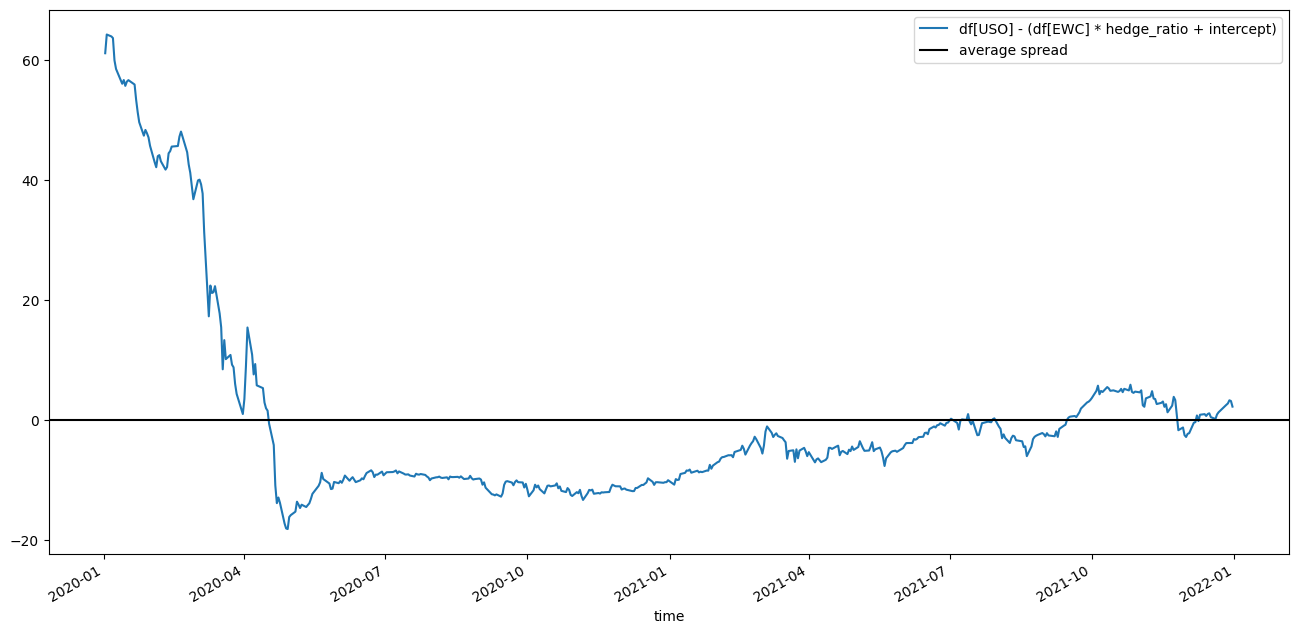

hedge_ratio: 1.1651176407423116 intercept: 9.271771006847253


In [19]:
spread.plot(figsize=(16,8))
plt.axhline(spread.mean(), color='black')
plt.xlabel("time")
plt.legend([f"df[{pair[0]}] - (df[{pair[1]}] * hedge_ratio + intercept)", "average spread"])
plt.show()
print(f"hedge_ratio: {hedge_ratio} intercept: {intercept}")

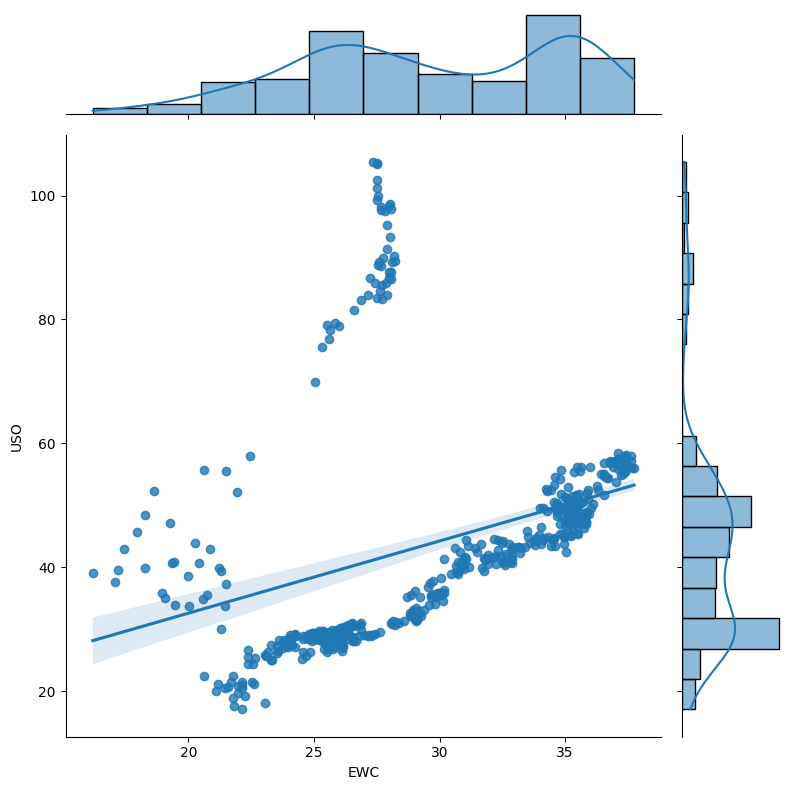

In [20]:
sns.jointplot(x=df[pair[1]], y=df[pair[0]], height=8, kind="reg")
plt.show()